In [2]:
# Define paths
image_folder = '/content/drive/MyDrive/biomed/short_data/images'
mask_folder = '/content/drive/MyDrive/biomed/short_data/masks/arm'

Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 0.7581 - accuracy: 0.8334 
Epoch 1: loss improved from inf to 0.75809, saving model to /content/drive/MyDrive/biomed/modelUNET.h5
2/2 [==============================] - 30s 16s/step - loss: 0.7581 - accuracy: 0.8334 - val_loss: 0.7770 - val_accuracy: 0.7968
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 0.7480 - accuracy: 0.8334 
Epoch 2: loss improved from 0.75809 to 0.74798, saving model to /content/drive/MyDrive/biomed/modelUNET.h5
2/2 [==============================] - 28s 16s/step - loss: 0.7480 - accuracy: 0.8334 - val_loss: 0.7633 - val_accuracy: 0.7968
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.8334 
Epoch 3: loss improved from 0.74798 to 0.73836, saving model to /content/drive/MyDrive/biomed/modelUNET.h5
2/2 [==============================] - 30s 16s/step - loss: 0.7384 - accuracy: 0.8334 - val_loss: 0.7506 - val_accuracy: 0.7968
Epoch 4/50
2/2 [====

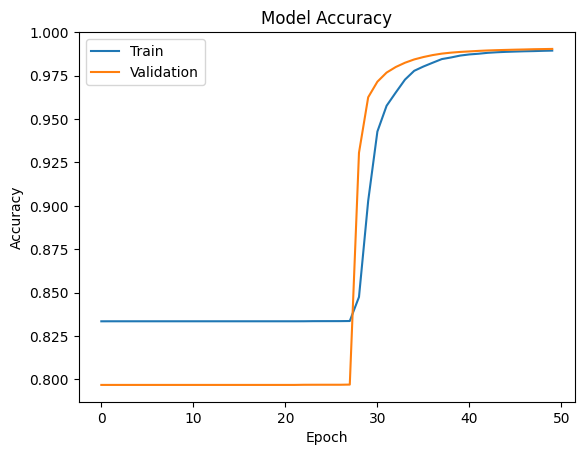

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

def load_image(image_path):
    img = cv2.imread(image_path)
    return img

# Load images
image_files = sorted(os.listdir(image_folder))
mask_files = sorted(os.listdir(mask_folder))

# Make sure masks correspond to images
images = []
masks = []
for image_file in image_files:
    base_name = os.path.splitext(image_file)[0]  # remove extension
    corresponding_mask_file = base_name + '_arm_mask.png'
    if corresponding_mask_file in mask_files:
        images.append(load_image(os.path.join(image_folder, image_file)))
        masks.append(cv2.imread(os.path.join(mask_folder, corresponding_mask_file), cv2.IMREAD_GRAYSCALE))

X = np.array(images)
Y = np.array(masks)

# Normalize images
X = X / 255
Y = Y / 255

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# Define the input layer
input_layer = Input((1980, 2972, 3))

def build_model(input_layer, start_neurons):
    # U-Net model
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    pool1 = MaxPooling2D((2, 2))(conv1)

    up = concatenate([UpSampling2D((2, 2))(pool1), conv1], axis=-1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(up)
    
    return output_layer

output_layer = build_model(input_layer, 16)

# Create an instance of the model
model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

# Specify the file path where you want to save the model
model_file = '/content/drive/MyDrive/biomed/modelUNET.h5'

model_checkpoint = ModelCheckpoint(model_file, monitor='loss', verbose=1, save_best_only=True)

# Train the model and save the history object
history = model.fit(X_train, y_train, batch_size=2, epochs=50, verbose=1, validation_data=(X_test, y_test), callbacks=[model_checkpoint])

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#


1/1 [==============================] - 3s 3s/step


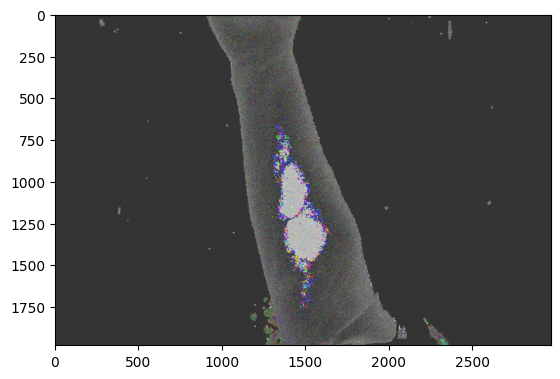

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the test image
test_image = cv2.imread('/content/drive/MyDrive/biomed/firstRun/test/084.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  # Convert to RGB
test_image = test_image / 255.0  # Normalize image

# Make a prediction using the trained model
prediction = model.predict(np.array([test_image]))

# Extract the predicted mask from the prediction
predicted_mask = prediction[0, :, :, 0]

# Convert the predicted mask to a color image
predicted_mask_color = cv2.cvtColor(predicted_mask, cv2.COLOR_GRAY2RGB)

# Resize the predicted mask to match the size of the original image
predicted_mask_color = cv2.resize(predicted_mask_color, test_image.shape[:2][::-1])

# Convert the test image to uint8 data type
test_image_uint8 = (test_image * 255).astype(np.uint8)

# Blend the predicted mask and the original image together
alpha = 0.5  # Set the blending factor
blended_image = cv2.addWeighted(test_image_uint8, alpha, predicted_mask_color, 1 - alpha, 0, dtype=cv2.CV_32F)

# Convert the blended image back to uint8 data type
blended_image = (blended_image * 255).astype(np.uint8)

# Visualize the blended image
plt.imshow(blended_image)
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
